In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice, chain
from functools import lru_cache

In [2]:
%matplotlib inline

In [3]:
from edgecaselib.formats import load_index, load_kmerscan, EmptyKmerscanError
from scipy.stats import entropy
from os import path
from pickle import load, dump
from gzip import open as gzopen

from scipy.stats import gaussian_kde
from scipy.signal import argrelmin

In [4]:
ECX = load_index("assets/hg38ext.fa.ecx")

In [5]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}

In [6]:
KMERSCANS_PKL = "PacBio/kmerscans-for-entropy.pkl.gz"

if path.isfile(KMERSCANS_PKL):
    with gzopen(KMERSCANS_PKL, mode="rb") as pkl:
        KMERSCANS = load(pkl)
else:
    KMERSCANS = {}
    for subject, trio in SUBJECT_TO_TRIO.items():
        try:
            ksp = load_kmerscan(
                f"PacBio/{trio}/{subject}/kmerscanner-all-p_arm.dat.gz",
                gzipped=True, samfilters=["tract_anchor", 3844, 0],
                bin_size=10,
            )
        except EmptyKmerscanError:
            ksp = {}
        try:
            ksq = load_kmerscan(
                f"PacBio/{trio}/{subject}/kmerscanner-all-q_arm.dat.gz",
                gzipped=True, samfilters=["is_q|tract_anchor", 3844, 0],
                bin_size=10,
            )
        except EmptyKmerscanError:
            ksq = {}
        KMERSCANS[subject] = (ksp, ksq)
    with gzopen(KMERSCANS_PKL, mode="wb") as pkl:
        dump(KMERSCANS, pkl)

In [7]:
def get_per_read_modes(bdf, chrom, prime, ecx, background=()):
    anchors = ecx.loc[
        (ecx["rname"]==chrom) & (ecx["prime"]==prime) & (ecx["flag"]==16384),
        "pos"
    ]
    assert len(anchors) == 1
    anchor = anchors.iloc[0]
    if prime == 3:
        positions = [c for c in bdf.columns[9:] if c >= anchor]
    elif prime == 5:
        positions = [c for c in bdf.columns[9:] if c <= anchor]
    else:
        raise ValueError
    bdf_slice = bdf[list(bdf.columns[:9]) + positions]
    return (
        bdf_slice[~bdf_slice["motif"].isin(background)].groupby("name")
        .apply(lambda block: block.set_index("motif").iloc[:,8:].idxmax(axis=0))
        .dropna(how="all", axis=1)
    )

In [8]:
def calculate_entropies(bdf, chrom, prime, ecx, background=()):
    per_read_modes = get_per_read_modes(bdf, chrom, prime, ecx, background=background)
    N = len(per_read_modes.melt().value.dropna().unique())
    return pd.DataFrame({
        "entropy": per_read_modes.apply(lambda c: entropy(c.value_counts())) / np.log(N),
        "coverage": (~per_read_modes.isnull()).sum(axis=0),
    })

In [9]:
PER_ARM_ENTROPIES = defaultdict(lambda: {"p": None, "q": None})

for subject, (ksp, ksq) in KMERSCANS.items():
    try:
        PER_ARM_ENTROPIES[subject]["p"] = pd.concat(
            calculate_entropies(bdf, chrom, 5, ECX)
            for chrom, bdf in tqdm(ksp.items(), desc=f"{subject}, p arm", unit="chromosome")
        )
    except ValueError:
        pass
    try:
        PER_ARM_ENTROPIES[subject]["q"] = pd.concat(
            calculate_entropies(bdf, chrom, 3, ECX)
            for chrom, bdf in tqdm(ksq.items(), desc=f"{subject}, q arm", unit="chromosome")
        )
    except ValueError:
        pass

HG004, q arm: 100%|██████████| 6/6 [00:06<00:00,  1.01s/chromosome]
HG005, p arm: 0chromosome [00:00, ?chromosome/s]
HG007, q arm: 100%|██████████| 9/9 [00:04<00:00,  1.91chromosome/s]


In [68]:
def get_kde(data, n_points=1000, bw=.075, scale=None):
    kde_x = np.linspace(data.min(), data.max(), n_points)
    kde_y = gaussian_kde(data, bw_method=bw).pdf(kde_x)
    kink = kde_x[argrelmin(kde_y)[0]][0]
    if scale:
        return kde_x, kde_y*scale/kde_y.max(), kink
    else:
        return kde_x, kde_y, kink

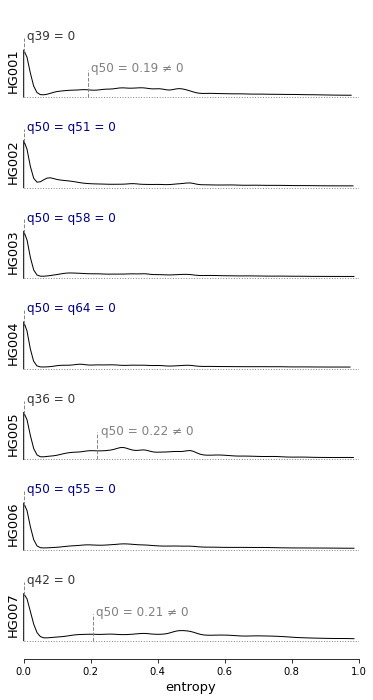

In [227]:
figure, ax = subplots(figsize=(6, 12))
for i, subject in enumerate(sorted(PER_ARM_ENTROPIES)):
    entropies_list = []
    if PER_ARM_ENTROPIES[subject]["p"] is not None:
        entropies_list.append(PER_ARM_ENTROPIES[subject]["p"]["entropy"].values)
    if PER_ARM_ENTROPIES[subject]["q"] is not None:
        entropies_list.append(PER_ARM_ENTROPIES[subject]["q"]["entropy"].values)
    dataset = np.concatenate(entropies_list)
    perc_zeros = 100 * sum(dataset==0) / len(dataset)
    q50 = np.median(dataset)
    q75 = np.quantile(dataset, .75)
    ax.plot((0, 1), [i, i], color="#888", lw=1, ls=":")
    estimator, kde, _ = get_kde(dataset, n_points=100, bw=.075, scale=.5)
    ax.plot(
        np.concatenate([[0], estimator]),
        np.concatenate([[i], i-kde-.02]),
        color="black", lw=1, alpha=1, clip_on=False,
    )
    if perc_zeros >= 50:
        ax.text(
            x=.01, y=i-.6, va="bottom", ha="left", fontsize=12, color="navy",
            s=f"q50 = q{perc_zeros:.0f} = 0",
        )
    else:
        ax.text(
            x=.01, y=i-.6, va="bottom", ha="left", fontsize=12, color="#333",
            s=f"q{perc_zeros:.0f} = 0",
        )
        ax.text(
            x=q50+.01, y=i-.25, va="bottom", ha="left", fontsize=12, color="gray",
            s=f"q50 = {q50:.2f} ≠ 0",
        )
        ax.plot([q50, q50], [i, i-.3], color="#888", lw=1, ls="--")
    ax.plot([0, 0], [i-.5, i-.65], color="#888", lw=1, ls="--")

ax.set_xlabel("entropy", fontsize=13)
ax.set(
    xlim=(0, 1), ylim=(6.2, -1), ylabel=None,
    yticks=np.arange(0, len(PER_ARM_ENTROPIES))-.05, yticklabels=sorted(PER_ARM_ENTROPIES),
)
for tick in ax.get_yticklabels():
    tick.set(rotation=90, va="bottom", fontsize=13)
ax.tick_params(axis="y", which="both", length=0)
for spine in "top", "left", "right":
    ax.spines[spine].set(visible=False)

figure.savefig("Figure 3, entropy.pdf", bbox_inches="tight")